# Business Creation Trends During the COVID-19 Pandemic in Belgium

Load the necessary libraries and set up the environment for data analysis.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

# Connect to KBO database
conn = sqlite3.connect(r'./data/kbo_database.db')

## How Many Companies Were Created During the Pandemic?

In [18]:
query = """
    SELECT
        CAST(SUBSTR(StartDate, 7, 4) AS INTEGER) AS Year,
        COUNT(DISTINCT EnterpriseNumber) AS CompaniesCount
    FROM enterprise
    WHERE StartDate IS NOT NULL
        AND CAST(SUBSTR(StartDate, 7, 4) AS INTEGER) > 2017
    GROUP BY Year
    ORDER BY Year;
"""
df_companies_count = pd.read_sql_query(query, conn)
df_companies_count.head(10)

,Year,CompaniesCount
0,2018,73309
1,2019,81171
2,2020,84786
3,2021,100446
4,2022,105626
5,2023,115432
6,2024,130923
7,2025,74092


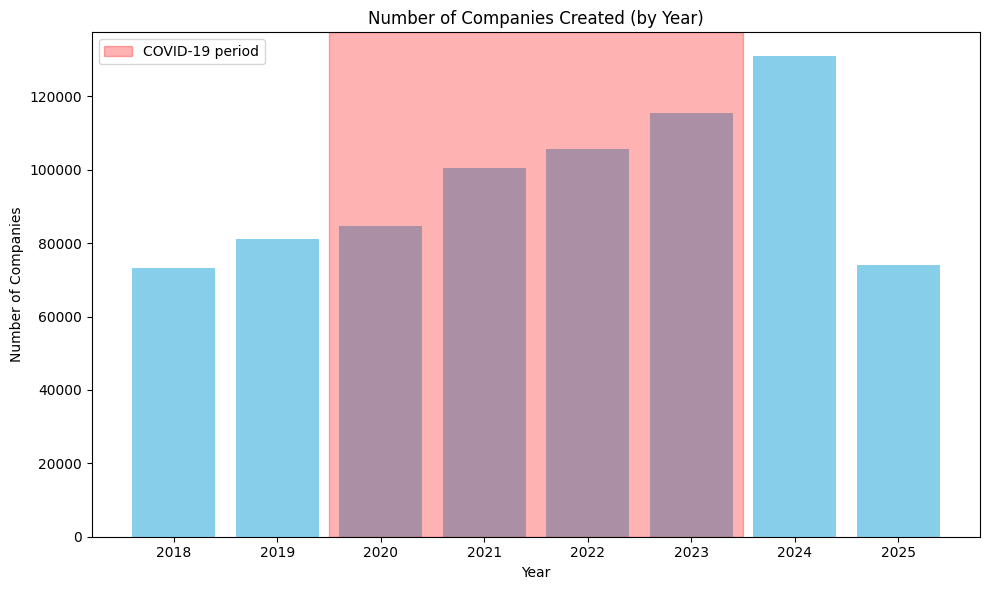

In [20]:
plt.figure(figsize=(10,6))
plt.bar(df_companies_count['Year'], df_companies_count['CompaniesCount'], color='skyblue')

# Highlight full 2020–2021 COVID period
plt.axvspan(2019.5, 2023.5, color='red', alpha=0.3, label='COVID-19 period')

# Set all years on x-axis
plt.xticks(df_companies_count['Year'])

plt.title('Number of Companies Created (by Year)')
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.legend()
plt.tight_layout()
plt.show()

## Where Were Companies Created During COVID?

In [59]:
query = """
    SELECT 
        a.MunicipalityFR,
        COUNT(DISTINCT a.EntityNumber) AS Count
    FROM enterprise e
    JOIN address a 
        ON e.EnterpriseNumber = a.EntityNumber
    WHERE StartDate IS NOT NULL
        AND CAST(SUBSTR(StartDate, 7, 4) AS INTEGER) BETWEEN 2020 AND 2023
        AND a.TypeOfAddress = 'REGO'
    GROUP BY a.MunicipalityFR
    ORDER BY Count DESC
    LIMIT 5;
"""
df_companies_per_region = pd.read_sql_query(query, conn)
df_companies_per_region.head()

,MunicipalityFR,Count
0,Antwerpen,12360
1,Bruxelles,6515
2,Gent,6499
3,Ixelles,3279
4,Liège,2826


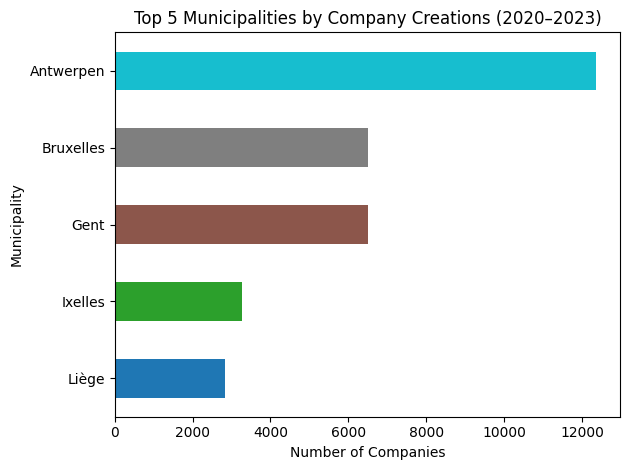

In [60]:
df_sorted = df_companies_per_region.sort_values(by='Count', ascending=False).iloc[::-1]

# Generate a list of unique colors (same length as the dataframe)
cmap = plt.colormaps['tab10'].resampled(len(df_sorted ))
colors = cmap(np.arange(len(df_sorted)))

# Plot with custom colors
df_sorted .plot(
    kind='barh',
    x='MunicipalityFR',
    y='Count',
    color=colors,
    legend=False
)

plt.title('Top 5 Municipalities by Company Creations (2020–2023)')
plt.xlabel('Number of Companies')
plt.ylabel('Municipality')
plt.tight_layout()
plt.show()

## Which Sectors Boomed During the Pandemic?

In [55]:
query = """
    SELECT 
        a.NaceCode,
        COUNT(DISTINCT a.EntityNumber) AS Count
    FROM activity AS a
    JOIN enterprise AS e 
        ON a.EntityNumber = e.EnterpriseNumber
    WHERE CAST(SUBSTR(StartDate, 7, 4) AS INTEGER) BETWEEN 2020 AND 2023
        AND a.Classification = 'MAIN'
    GROUP BY a.NaceCode
    ORDER BY Count DESC
    LIMIT 15;
"""
df_companies_per_sector = pd.read_sql_query(query, conn)

query_code = """
    SELECT Code, Description
    FROM code
    WHERE Category IN ('Nace2003', 'Nace2008', 'Nace2025') 
        AND Language = 'FR'
"""
df_codes = pd.read_sql_query(query_code, conn)

# Ensure types match for the merge key
df_companies_per_sector['NaceCode'] = df_companies_per_sector['NaceCode'].astype(str)
df_codes['Code'] = df_codes['Code'].astype(str)

# Merge on code
df_merged = df_companies_per_sector.merge(df_codes, left_on='NaceCode', right_on='Code', how='left')

# Drop the 'NaceCode' column and rename 'Description'
df_merged = df_merged.drop(columns=['NaceCode'])
df_merged = df_merged.rename(columns={'Description': 'Sector'})

# Reorder columns
df_merged = df_merged[['Sector', 'Count']]

# Define a mapping of similar/duplicate sector descriptions to unified English labels
sector_mapping = {
    'Activités de conseil pour les affaires et autre conseil de gestion': 'Management consulting',
    'Conseil pour les affaires et autres conseils de gestion': 'Management consulting',
    'Construction générale de bâtiments résidentiels': 'Residential construction',
    'Transports aériens non réguliers': 'Non-scheduled air transport',
    'Activités de conseil en informatique et de gestion d’installations informatiques': 'IT consulting & infrastructure management',
    'Conseil informatique': 'IT consulting & infrastructure management',
    'Autres activités de soutien aux entreprises n.c.a.': 'Business support services',
    'Autres activités de service de soutien aux entreprises nca': 'Business support services',
    'Soins esthétiques et autres activités de traitement esthétique': 'Personal care services'
}


df_merged['SectorGroup'] = df_merged['Sector'].map(sector_mapping)

df_cleaned = df_merged.dropna(subset=['SectorGroup'])

df_grouped = (
    df_cleaned
    .groupby('SectorGroup', as_index=False)['Count']
    .sum()
    .sort_values(by='Count', ascending=False)
    .head(5)
)

df_grouped.head()

,SectorGroup,Count
2,Management consulting,41725
5,Residential construction,19434
1,IT consulting & infrastructure management,17319
0,Business support services,15772
3,Non-scheduled air transport,8806


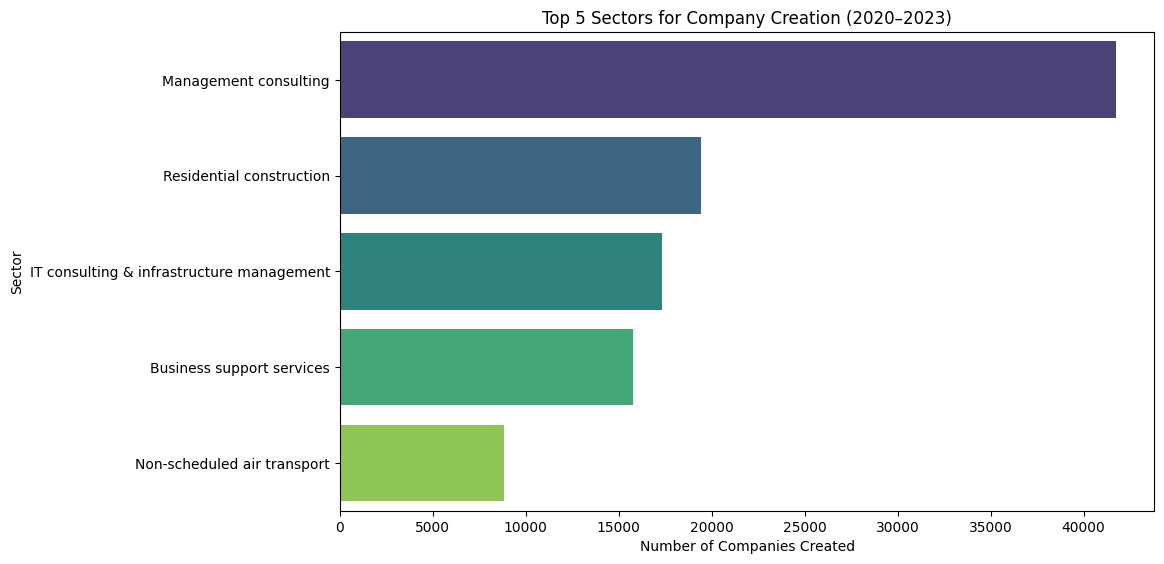

In [56]:
plt.figure(figsize=(12, 6))

# Horizontal barplot for better readability of sector names
sns.barplot(x='Count', y='SectorGroup', data=df_grouped, palette='viridis', hue='SectorGroup', dodge=False, legend=False)

plt.title('Top 5 Sectors for Company Creation (2020–2023)')
plt.xlabel('Number of Companies Created')
plt.ylabel('Sector')
plt.tight_layout(pad=2.0)
plt.show()
